# Testing STFT solver implemented on STM32

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import librosa
from IPython import display
import csv

from DSP_prototype import DSP_algorithms

### Audio and STFT files path

In [2]:
audio_file = "../Data_acquisition/data/audio/8kHz_sampling/go_fs=8kHz_3.csv"
stft_file = "../Data_acquisition/data/stft/8kHz_sampling/stft_go_fs=8kHz_3.csv"

In [3]:
audio_data = []
with open(audio_file, 'r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        audio_data.append(float(row['y']))  # Convert to int if y is numeric

audio_data = np.array(audio_data, dtype=np.float32)
print(f"Data length before resampling: {len(audio_data)}")
print(f"Data type before resampling: {type(audio_data[0])}")
display.Audio(audio_data, rate=8000, autoplay=True)

Data length before resampling: 8000
Data type before resampling: <class 'numpy.float32'>


## STFT using implemented Python solver

Number of frames: 61
signal_shape: (8000,)
STFT matrix shape: (129, 61)


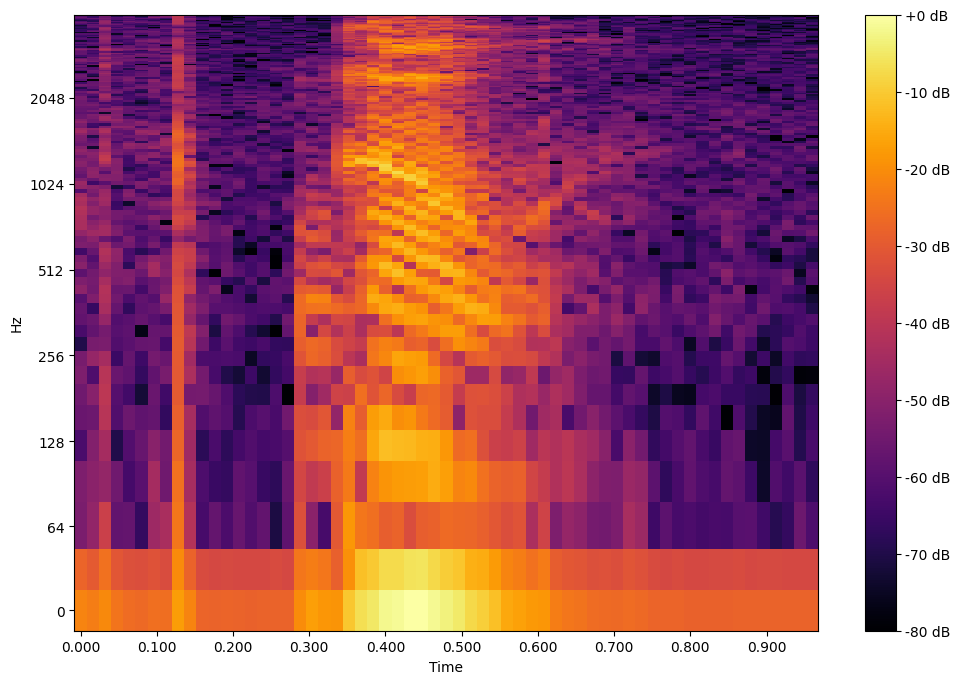

In [4]:
fs = 8e3
window_size = 256
hop_size = 128

stft_matrix, freq_bins, time_frames = DSP_algorithms.stft(audio_data, fs=fs, N=window_size, hop_size=hop_size,
                                                          window_type='hann', verbose=True)

print(f"STFT matrix shape: {stft_matrix.shape}")

S_db = librosa.amplitude_to_db(np.abs(stft_matrix), ref=np.max)

plt.figure(figsize=(12, 8))
librosa.display.specshow(S_db, x_axis='time', y_axis='log', sr=fs, cmap='inferno',
                         hop_length=128)
plt.colorbar(format='%+2.0f dB')
plt.show()

## STFT using implemented STM32 solver

In [6]:
stft_data = []
with open(stft_file, 'r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        stft_data.append(float(row['stft_value']))  # Convert to int if y is numeric

stft_data = np.array(stft_data, dtype=np.float32)
print(f"stft_data shape: {stft_data.shape}")

stft_data shape: (7869,)


STFT matrix shape: (129, 61)


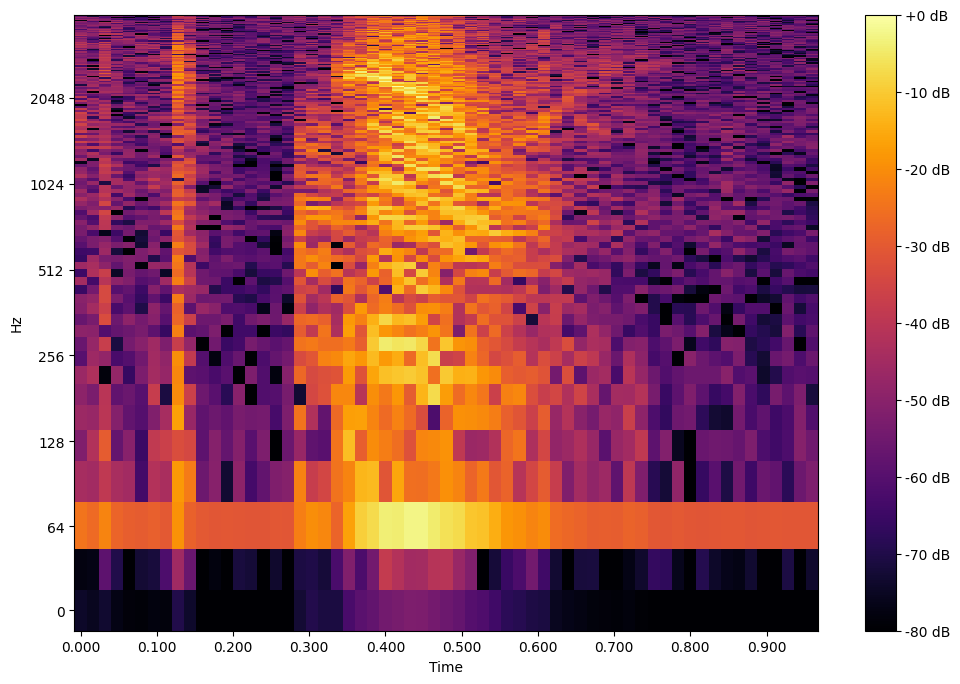

In [7]:
hop_size = 128
N = 256

num_frames = (len(stft_data) - (N // 2 + 1)) // (N // 2 + 1) + 1
frame_length = N // 2 + 1

if len(stft_data) != num_frames * frame_length:
    raise ValueError("STFT data length does not match expected frame count and frequency")

stft_matrix = np.reshape(stft_data, (frame_length, num_frames), order='F')
print(f"STFT matrix shape: {stft_matrix.shape}")

S_db = librosa.amplitude_to_db(np.abs(stft_matrix), ref=np.max)

plt.figure(figsize=(12, 8))
librosa.display.specshow(S_db, x_axis='time', y_axis='log', sr=fs, cmap='inferno',
                         hop_length=128)
plt.colorbar(format='%+2.0f dB')
plt.show()

STFT matrix shape: (129, 61)


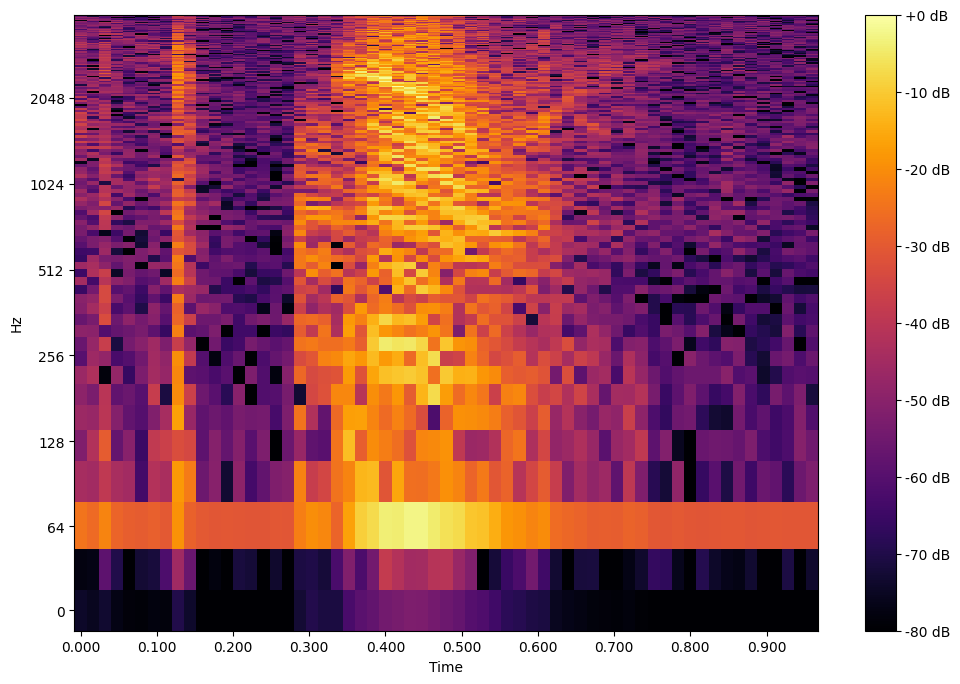

In [8]:
hop_size = 128
N = 256

num_frames = (len(stft_data) - (N // 2 + 1)) // (N // 2 + 1) + 1
frame_length = N // 2 + 1

if len(stft_data) != num_frames * frame_length:
    raise ValueError("STFT data length does not match expected frame count and frequency")

stft_matrix = np.reshape(stft_data, (frame_length, num_frames), order='F')
print(f"STFT matrix shape: {stft_matrix.shape}")

S_db = librosa.amplitude_to_db(np.abs(stft_matrix), ref=np.max)

plt.figure(figsize=(12, 8))
librosa.display.specshow(S_db, x_axis='time', y_axis='log', sr=fs, cmap='inferno',
                         hop_length=128)
plt.colorbar(format='%+2.0f dB')
plt.show()